In [3]:
import requests
import zipfile
import numpy as np
import pandas as pd
import datetime
url = 'http://labfile.oss.aliyuncs.com/courses/1213/mnist.zip'
local_filename = url.split('/')[-1]  
with requests.get(url, stream=True) as r:
    with open(local_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)

with zipfile.ZipFile(local_filename, 'r') as zip_ref:
    zip_ref.extractall('.')
    extracted_files = zip_ref.namelist()

for file in extracted_files:
    print(file)


mnist/
mnist/train-labels.idx1-ubyte
mnist/train-images.idx3-ubyte
mnist/t10k-labels.idx1-ubyte
mnist/t10k-images.idx3-ubyte


In [4]:
from sklearn.preprocessing import OneHotEncoder
import math

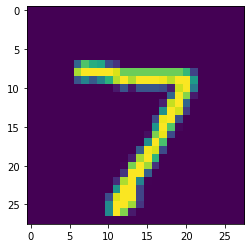

In [5]:
import struct
import numpy as np


def read_mnist(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)


mnist_test_data = read_mnist('mnist/t10k-images.idx3-ubyte')
mnist_train_data = read_mnist('mnist/train-images.idx3-ubyte')
mnist_train_labels = read_mnist('mnist/train-labels.idx1-ubyte')
mnist_test_labels = read_mnist('mnist/t10k-labels.idx1-ubyte')

import matplotlib.pyplot as plt

plt.imshow(mnist_test_data[0, :, :])

In [6]:
labels = [[1], [2], [3]]  
encoder = OneHotEncoder()
encoder.fit_transform(labels).toarray()
encoder.fit(np.arange(10).reshape((-1, 1)))  #hotencoder for dataset

mnist_test_labels = encoder.transform(np.reshape(
    mnist_test_labels, (-1, 1))).toarray()  

mnist_train_labels = encoder.transform(np.reshape(
    mnist_train_labels, (-1, 1))).toarray()  


mnist_train_data = (np.reshape(
    mnist_train_data, (mnist_train_data.shape[0], -1))-127.0)/255.0

mnist_test_data = (np.reshape(
    mnist_test_data, (mnist_test_data.shape[0], -1))-127.0)/255.0

mnist_train_data.shape, mnist_test_data.shape

((60000, 784), (10000, 784))

In [7]:
def softmax(input):
    assert len(input.shape) == 2 
    exp_value = np.exp(input)  
    output = exp_value/np.sum(exp_value, axis=1)[:, np.newaxis]  
    return output

test_data = np.array([[3.2, 5.1, -1.7]])

N, C = 100, 3
test_data = np.random.randn(N, C) 

test_labels = encoder.fit_transform(np.random.randint(0, C, (N, 1))).toarray()
prob = softmax(test_data)  

loss = np.sum(-np.log(prob) * test_labels) / N


  0%|          | 0/900 [00:00<?, ?it/s]

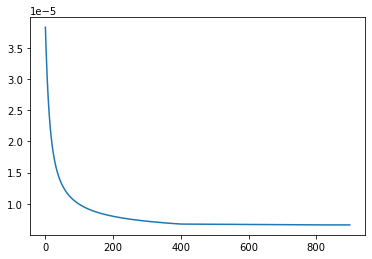

In [35]:
class lr_scheduler(object):
    def __init__(self, base_lr, step_size, deacy_factor=0.1):
        self.base_lr = base_lr 
        self.deacy_factor = deacy_factor  
        self.step_count = 0  
        self.lr = base_lr 
        self.step_size = step_size  

    def step(self, step_count=1):  
        self.step_count += step_count

    def get_lr(self):
        self.lr = self.base_lr * \
            (self.deacy_factor**(self.step_count//self.step_size)) 
        return self.lr



class CrossEntropyLossLayer():
    def __init__(self):
        pass

    def forward(self, input, labels):
        assert len(input.shape) == 2, 'input muet be a two-d array'
        assert len(labels.shape) == 2, 'input label mut be indepentended encroded'
        assert labels.shape == input.shape, 'the label and the input must habe same number'
        self.data = input
        self.labels = labels
        self.prob = np.clip(softmax(input), 1e-9, 1.0)  
        loss = -np.sum(np.multiply(self.labels, np.log(self.prob))
                       )/self.labels.shape[0]
        return loss

    def backward(self):
        self.grad = (self.prob - self.labels)/self.labels.shape[0]

N, C = 10, 3

pred_prob = np.random.randn(N, C) 
labels = encoder.fit_transform(
    np.random.randint(0, C, (N, 1))).toarray()  

loss_layer = CrossEntropyLossLayer()
loss = loss_layer.forward(pred_prob, labels)
loss_layer.backward()
loss, loss_layer.grad

from tqdm.notebook import tqdm

D_in, D_out = 784, 10

base_lr = 0.1

max_iter = 900

step_size = 400

scheduler = lr_scheduler(base_lr, step_size)
W = np.random.randn(D_in, D_out)*0.01  

best_acc = -float('inf')
best_weight = None  
loss_list = []
for _ in tqdm(range(max_iter)):
    test_pred = np.dot(mnist_test_data, W)
    pred_labels = np.argmax(test_pred, axis=1)
    real_labels = np.argmax(mnist_test_labels, axis=1)
    acc = np.mean(pred_labels == real_labels)
    if acc > best_acc:
        best_acc = acc
        best_weight = W  
    train_pred = np.dot(mnist_train_data, W)
    loss = loss_layer.forward(train_pred, mnist_train_labels)
    loss_list.append(loss/mnist_train_data.shape[0])  
    loss_layer.backward()
    grad = np.dot(mnist_train_data.T, loss_layer.grad)
    W -= scheduler.get_lr()*grad
    scheduler.step()

plt.plot(list(range(max_iter)), loss_list)

array([1], dtype=int64)

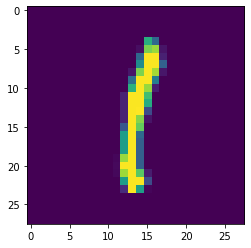

In [47]:
import random
test_index = random.randint(0, mnist_test_data.shape[0]-1)
test_img = mnist_test_data[test_index, :]
plt.imshow(test_img.reshape((28, 28)))
prob = softmax(np.dot(test_img[np.newaxis, :], W)) 
np.argmax(prob, axis=1)  